# TITAN Tutorial

---

<img align="right" width="300" height="300" src="../images/hail_case_tracks.png">

This interactive tutorial takes you through the steps of how to run the Thunderstorm Identification, Tracking, Analysis and Nowcasting (TITAN) suite. TITAN was originally designed as an algorithm to objectively identify and track thunderstorms from weather radar data for a weather modification experiment in South Africa in the 1980s. Now, Titan includes forecasting, storm analysis, and climatological analysis. TITAN now refers to the larger system in which the original application is one component.

Titan is described in more detail in [Dixon and Wiener (1993)](https://doi.org/10.1175/1520-0426(1993)010%3C0785:TTITAA%3E2.0.CO;2).


---

## Titan Background

TITAN identifies storm objects as a contiguous region of echo that exceeds a user-defined reflectivity threshold and minimum volume. Dual thresholds are used to deal with storm objects that briefly touch, but do not merge. Storm tracking is performed by looking for regions of overlap between storm objects at successive time intervals. Short term storm extrapolation forecasts are used to identify instances of storm merging and splitting. TITAN output includes storm tracks, polygons outlining the storm objects, and storm property information (e.g., volume, area, mass, precipitation flux).

The high-level workflow for TITAN is shown in the graphic below. Key steps include quality controlling the data to remove any non-meteorological or compromised echoes and gridding the data to a Cartesian grid. Once TITAN is run and the tracks are produced, those data need to be converted into more user-friendly file types. 

<img align="center" width="600" src="../images/lrose/titan_highlevel.png">

A more detailed workflow for TITAN that includes each step, application, and data type is shown in the graphic below.

<img align="center" width="800" src="../images/lrose/titan_data_flow.png">

## Tutorial Overview
### 1. Setup

#### Download raw data and prepare parameter files

Raw data files that are provided:
* A hail storm in Alberta, observed by the Strathmore radar 40 km east Calgary.
* A derecho event in Ontario, observed by the King City radar 40 km north of Toronto.

Both of these are 10 cm (S-band) Gematronik dual polarization radars.

The data (as a .tgz file) has been provided in the form of a zipped tar file, which we will unzip create the following tree:

```
  ./data/titan/ERA5/20220521
  ./data/titan/ERA5/20240806
  ./data/titan/radar/raw/hail/20240806*.h5
  ./data/titan/radar/raw/derecho/20220521*.h5
```

### 2. Output data

After the full analysis has been run, the following derived data directories should exist:

```
  ./data/titan/ERA5/spdb/Strathmore/20240806* (soundings from ERA5)
  ./data/titan/ERA5/spdb/KingCity/20220521* (soundings from ERA5)
  ./data/titan/radar/cfradial/qc/Strathmore/20240806/cfrad.20240806*nc (cfradial after QC)
  ./data/titan/radar/cfradial/qc/KingCity/20220521/cfrad.20220521*nc (cfradial after QC)
  ./data/titan/radar/cfradial/pid/Strathmore/20240806/cfrad.20240806*nc (cfradial PID)
  ./data/titan/radar/cfradial/pid/Strathmore/20240806/cfrad.20240806*nc (cfradial PID)
  ./data/titan/radar/cart/qc/Strathmore/20240806/ncf_20240806*nc (Cartesian MDC CF-compliant netcdf)
  ./data/titan/radar/cart/qc/KingCity/20220521/ncf_202205216*nc (Cartesian MDC CF-compliant netcdf)
  ./data/titan/titan/storms/Strathmore/20240806* (Titan binary files)
  ./data/titan/titan/storms/KingCity/20220521* (Titan binary files)
  ./data/titan/titan/ascii/Tracks2Ascii.hail.txt (Titan output converted by Tracks2Ascii)
  ./data/titan/titan/ascii/Tracks2Ascii.derecho.txt (Titan output converted by Tracks2Ascii)
  ./data/titan/titan/netcdf/Strathmore/titan_20240806.nc (Titan output converted by Tstorms2NetCDF)
  ./data/titan/titan/netcdf/KingCity/titan_20220521.nc (Titan output converted by Tstorms2NetCDF)
```

### 3. Note on task cells

This notebook uses two colored cells to indicate tasks.

<div class="alert alert-block alert-info"> <b>File Task: modify parameters in text files.</b> 

These text blocks help the user modify the parameter files or other functions in *external* text files.

</div>

<div class="alert alert-block alert-warning"> <b>Cell Task: run a command in Jupyter notebook cell.</b> 

These text blocks instruct the users to run a command *in* a cell within the Jupyter notebook. If you prefer, you are welcome to copy the commands (minus the ! symbol) into a terminal window.

</div>

---

# 1. Setup
## Environment and packages

First, we import the required python packages to run this notebook. Most of the LROSE processing can be done with the os package and shell commands.

In [1]:
import os
import subprocess

import warnings

warnings.filterwarnings("ignore")

import os
import fsspec
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy import feature as cfeature
import xarray as xr
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## 1.1 Set up directories

We need to set up the required data directories. The raw radar data will be grabbed from the S3 bucket. We delete any existing files and directories specific to this tutorial to ensure we're starting with clean directories and files.

In [2]:
# make overall titan directory and application output directory
!mkdir -p ./data/titan/titan

# make directory for output ascii files from TITAN
!mkdir -p ./data/titan/titan/ascii

## 1.2 Set up the environment

First, we'll set some key variables we'll need throughout the workflow.

In [3]:
# Set directory variable to call LROSE
os.environ["LROSE_DIR"] = "/usr/local/lrose/bin"
os.environ["DATA_DIR"] = "./"

## 1.3 Get data

Because some of the preprocessing requires ancillary data, we need to grab and untar that data.

In [4]:
import os
import fsspec
import shutil

# Remote endpoint and path
URL = "https://js2.jetstream-cloud.org:8001/"
path = "pythia/radar/ams2025"

# Initialize filesystem
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))

# Get list of files (example: Ontario Derecho)
files = fs.glob(f"{path}/OntarioDerecho2022/*.h5")

# Local base directory where you want to store files
local_base = "./radar/raw/derecho"

for remote_file in files:
    # Construct local file path, preserving the relative directory structure
    rel_path = os.path.relpath(remote_file, start=path)  
    local_file = os.path.join(local_base, rel_path)

    # Ensure parent directories exist
    os.makedirs(os.path.dirname(local_file), exist_ok=True)

    # Open remote and local files and copy
    with fs.open(remote_file, "rb") as fsrc, open(local_file, "wb") as fdst:
        shutil.copyfileobj(fsrc, fdst)

    print(f"Downloaded {remote_file} -> {local_file}")


Downloaded pythia/radar/ams2025/OntarioDerecho2022/2022052115_00_ODIMH5_PVOL6S_VOL_CASET.h5 -> ./radar/raw/derecho/OntarioDerecho2022/2022052115_00_ODIMH5_PVOL6S_VOL_CASET.h5
Downloaded pythia/radar/ams2025/OntarioDerecho2022/2022052115_00_ODIMH5_PVOL6S_VOL_CASKR.h5 -> ./radar/raw/derecho/OntarioDerecho2022/2022052115_00_ODIMH5_PVOL6S_VOL_CASKR.h5
Downloaded pythia/radar/ams2025/OntarioDerecho2022/2022052115_06_ODIMH5_PVOL6S_VOL_CASET.h5 -> ./radar/raw/derecho/OntarioDerecho2022/2022052115_06_ODIMH5_PVOL6S_VOL_CASET.h5
Downloaded pythia/radar/ams2025/OntarioDerecho2022/2022052115_06_ODIMH5_PVOL6S_VOL_CASKR.h5 -> ./radar/raw/derecho/OntarioDerecho2022/2022052115_06_ODIMH5_PVOL6S_VOL_CASKR.h5
Downloaded pythia/radar/ams2025/OntarioDerecho2022/2022052115_12_ODIMH5_PVOL6S_VOL_CASET.h5 -> ./radar/raw/derecho/OntarioDerecho2022/2022052115_12_ODIMH5_PVOL6S_VOL_CASET.h5
Downloaded pythia/radar/ams2025/OntarioDerecho2022/2022052115_12_ODIMH5_PVOL6S_VOL_CASKR.h5 -> ./radar/raw/derecho/OntarioDer

In [5]:
import os
import fsspec
import shutil

# Remote endpoint and path
URL = "https://js2.jetstream-cloud.org:8001/"
path = "pythia/radar/ams2025/lrose/ams2025/ERA5"

# Initialize filesystem
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))

# Get list of files (example: Ontario Derecho)
files = fs.glob(f"{path}/20220521/20220521_*")

# Local base directory where you want to store files
local_base = "./ERA5"

for remote_file in files:
    # Construct local file path, preserving the relative directory structure
    rel_path = os.path.relpath(remote_file, start=path)  
    local_file = os.path.join(local_base, rel_path)

    # Ensure parent directories exist
    os.makedirs(os.path.dirname(local_file), exist_ok=True)

    # Open remote and local files and copy
    with fs.open(remote_file, "rb") as fsrc, open(local_file, "wb") as fdst:
        shutil.copyfileobj(fsrc, fdst)

    print(f"Downloaded {remote_file} -> {local_file}")


Downloaded pythia/radar/ams2025/lrose/ams2025/ERA5/20220521/20220521_000000.mdv.cf.nc -> ./ERA5/20220521/20220521_000000.mdv.cf.nc
Downloaded pythia/radar/ams2025/lrose/ams2025/ERA5/20220521/20220521_010000.mdv.cf.nc -> ./ERA5/20220521/20220521_010000.mdv.cf.nc
Downloaded pythia/radar/ams2025/lrose/ams2025/ERA5/20220521/20220521_020000.mdv.cf.nc -> ./ERA5/20220521/20220521_020000.mdv.cf.nc
Downloaded pythia/radar/ams2025/lrose/ams2025/ERA5/20220521/20220521_030000.mdv.cf.nc -> ./ERA5/20220521/20220521_030000.mdv.cf.nc
Downloaded pythia/radar/ams2025/lrose/ams2025/ERA5/20220521/20220521_040000.mdv.cf.nc -> ./ERA5/20220521/20220521_040000.mdv.cf.nc
Downloaded pythia/radar/ams2025/lrose/ams2025/ERA5/20220521/20220521_050000.mdv.cf.nc -> ./ERA5/20220521/20220521_050000.mdv.cf.nc
Downloaded pythia/radar/ams2025/lrose/ams2025/ERA5/20220521/20220521_060000.mdv.cf.nc -> ./ERA5/20220521/20220521_060000.mdv.cf.nc
Downloaded pythia/radar/ams2025/lrose/ams2025/ERA5/20220521/20220521_070000.mdv.cf.

# 2. Prepare data for analysis

The following sections describe two quality control setups and how to run the scripts.

## 2.1: Option 1 - Apply quality control (QC) on the raw radar data and convert to CfRadial format using RadxConvert

In the hail case, there is no significant signal interference. 

<img align="center" width ="600" src="../images/lrose/hail.dbz.no_qc.png">

In the derecho case, considerable interference is present, appearing as radial spikes.  

<img align="center" width ="600" src="../images/lrose/derecho.dbz.no_qc.png">


Closer inspection of these spikes shows that the interference sources are not coherent with the radars, as indicated by:  

* Low SQI (NCP)  
* Moderately low SNR  

To address this, we use `RadxConvert` to censor data fields based on thresholds applied to the input fields. Specifically, data are removed at gates where **both** conditions are met:  

* SQI (NCP) < 0.2  
* SNR < 25 dB  

Since later QC steps require signal-to-noise ratio (SNR), the SNR field is derived from reflectivity (DBZ) and added during processing.  

Finally, the raw HDF5 files are converted to CfRadial format using `RadxConvert` with this simple quality control applied.  

<div class="alert alert-block alert-warning"> <b>Cell Task: Run QC on derecho case data.</b> 
    <br>
    Run the derecho case QC script:
    <br>
    <code lang="bash">!$LROSE_DIR/RadxConvert -sort_rays_by_time -const_ngates -params ./params/titan/RadxConvert.qc.derecho -debug -f ${DATA_DIR}/radar/raw/derecho/202205211*CASKR.h5</code>
</div>

In [6]:
# Run QC on derecho case data
!$LROSE_DIR/RadxConvert -sort_rays_by_time -const_ngates -params ./params/titan/RadxConvert.qc.derecho -f ./radar/raw/derecho/OntarioDerecho2022/202205211*CASKR.h5

Program 'RadxConvert'
Run-time 2025/08/23 21:41:37.

Copyright (c) 1992 - 2025
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to 

This simple QC removes some of the bad data, as shown by the screenshots below from the derecho case.

<img align="left" width ="600" src="../images/lrose/derecho.dbz.no_qc.png">
<img align="left" width ="600" src="../images/lrose/derecho.dbz.qc.png">

## 2.2: Option 2 - Computing PID as an alternative method of censoring using RadxPid

An alternative method for cleaning up interference is to run RadxPid, and censor non-meteorological echoes.

First, we have to download the ERA5 reanalysis for these cases, and we can use that to save the model-based soundings:

<div class="alert alert-block alert-warning"> <b>Cell Task: Run ERA5 sounding scripts.</b> 
    <br>
    Run the ERA5 sounding scripts:
    <br>
    <code lang="bash">!$LROSE_DIR/Mdv2SoundingSpdb -debug -params ./params/titan/Mdv2SoundingSpdb.ERA5.derecho -f $DATA_DIR/ERA5/20220521/20220521_*</code><br>
    
</div>

In [7]:
# Get the ERA5 sounding for derecho case data
!$LROSE_DIR/Mdv2SoundingSpdb -debug -params ./params/titan/Mdv2SoundingSpdb.ERA5.derecho -f ./ERA5/20220521/20220521_*

Program 'Mdv2SoundingSpdb'
Run-time 2025/08/23 21:43:48.

Copyright (c) 1992 - 2025
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as no

And we can then run RadxPid:

<div class="alert alert-block alert-warning"> <b>Cell Task: Run PID on derecho case data.</b> 
    <br>
    Run the derecho case PID script:
    <br>
    <code lang="bash">!$LROSE_DIR/RadxPid -params ./params/titan/RadxPid.derecho -debug</code>
</div>

In [8]:
# Run PID on derecho case data
!$LROSE_DIR/RadxPid -params ./params/titan/RadxPid.derecho -debug

Cannot stat file for parsing
pid_thresholds.sband.shv: No such file or directory
ERROR: RadxPid
Cannot read params file for NcarPid: pid_thresholds.sband.shv
Error: Could not create RadxPid object.


The following shows the PID field for the derecho case:

<img align="center" width ="600" src="../images/lrose/derecho.pid.png">

The interference is identified as clutter in this case.

And the following shows the raw data and after using PID to clean up the reflectivity field:

<img align="center" width ="600" src="../images/lrose/derecho.dbz.no_qc.png">
<img align="center" width ="600" src="../images/lrose/derecho.dbz.censored_by_pid.png">


For this tutorial we will use the QC data created by RadxConvert.

## 2.3: Convert to Cartesian grid using Radx2Grid

Titan requires input data in Cartesian coordinates, rather than polar.
To perform this transformation, we run the following to convert the data to Cartesian grid format.

<div class="alert alert-block alert-warning"> <b>Cell Task: Convert derecho case to Cartesian grid.</b> 
    <br>
    Run the derecho case grid conversion script:
    <br>
    <code lang="bash">!$LROSE_DIR/Radx2Grid -params ./params/titan/Radx2Grid.derecho -debug</code>
</div>

In [9]:
# Convert derecho case to Cartesian grid
!$LROSE_DIR/Radx2Grid -params ./params/titan/Radx2Grid.derecho

Program 'Radx2Grid'
Run-time 2025/08/23 21:43:58.

Copyright (c) 1992 - 2025
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to co

# 3. Run TITAN storm tracking

Run the TITAN algorithm to identify and track storms.

Titan runs on the Cartesian gridded data, using the DBZ field and optionally the VEL field to compute storm rotation.

<div class="alert alert-block alert-warning"> <b>Cell Task: Run TITAN on derecho case data.</b> 
    <br>
    Run the derecho case TITAN script:
    <br>
    <code lang="bash">!$LROSE_DIR/Titan -params ./params/titan/Titan.derecho -start "2022 05 21 12 00 00" -end "2022 05 21 20 00 00" -debug</code>
</div>

In [10]:
# Run TITAN on derecho case data
!$LROSE_DIR/Titan -params ./params/titan/Titan.derecho -start "2022 05 21 12 00 00" -end "2022 05 21 20 00 00"

Program 'Titan'
Run-time 2025/08/23 21:49:50.

Copyright (c) 1992 - 2025
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to confus

# 4. Convert TITAN binary output to readable format

## 4.1 Convert TITAN binary output to ASCII format for analysis.

<div class="alert alert-block alert-warning"> <b>Cell Task: Convert derecho case TITAN output to ASCII.</b> 
    <br>
    Run the derecho case ASCII conversion script:
    <br>
    <code lang="bash">!$LROSE_DIR/Titan -params ./params/titan/Titan.derecho -start "2022 05 21 12 00 00" -end "2022 05 21 20 00 00" -debug</code>
</div>

In [11]:
!$LROSE_DIR/Tracks2Ascii -params ./params/titan/Tracks2Ascii.derecho -f ./titan/storms/KingCity/20220521.th5 > ./data/titan/titan/ascii/Tracks2Ascii.derecho.txt

Program 'Tracks2Ascii'
Run-time 2025/08/23 21:50:08.

Copyright (c) 1992 - 2025
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to

In [12]:
# Convert derecho case TITAN output to ASCII
!$LROSE_DIR/Titan -params ./params/titan/Titan.derecho -start "2022 05 21 12 00 00" -end "2022 05 21 20 00 00"

Program 'Titan'
Run-time 2025/08/23 21:50:08.

Copyright (c) 1992 - 2025
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to confus

## 4.2: Convert TITAN output to NetCDF format

Convert TITAN binary output to NetCDF format for further analysis.

<div class="alert alert-block alert-warning"> <b>Cell Task: Convert derecho case TITAN output to NetCDF.</b> 
    <br>
    Run the derecho case NetCDF conversion script:
    <br>
    <code lang="bash">!$LROSE_DIR/Tstorms2NetCDF -params ./params/titan/Tstorms2NetCDF.derecho -debug -f $DATA_DIR/titan/storms/KingCity/20220521.sh5</code>
</div>

In [13]:
# Convert derecho case TITAN output to NetCDF
!$LROSE_DIR/Tstorms2NetCDF -params ./params/titan/Tstorms2NetCDF.derecho -f $DATA_DIR/titan/storms/KingCity/20220521.sh5

Program 'Tstorms2NetCDF'
Run-time 2025/08/23 21:50:26.

Copyright (c) 1992 - 2025
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not 

# 5. Plot Output

We'll load the necessary Python packages and plot some of the TITAN output now.

In [14]:
# Import Python packages
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon

In [15]:
file = "./data/titan/titan/ascii/Tracks2Ascii.derecho.txt"

Open text file and adjust columns names in order to import to a pandas dataframe. 
Since the text file has irregular delimiters, we need to add some extra steps.

In [16]:
#open file and extract column names
f = open(file)
lines = f.readlines()
f.close()

label_line_index = None  

for i, line in enumerate(lines):
    if 'labels' in line:
        label_line_index = i
        break  
labels = lines[label_line_index].split(":", 1)[1].strip().split(",")

In [17]:
#the data lines are the ones that do not start with #
data_lines = [line.strip() for line in lines if not line.startswith("#")]

The file last three rows are labeled "parents","children","nPolySidesPolygonRays*72". Parents and children columns refer to identifiers based on merging and splitting processes. The Polygon column shows the values for the lines from the polygon centroid to each vertex, in km. There are 72 values because each line is separated 5 deg (72*5 =360). With that information and the "envelope_centroid" column, we can retrieve the cells envelopes at each timestep.

In [18]:
rows = []
for line in data_lines:
    parts = line.split()

    try:
        # Try parsing the polygon count value (always right before 72 values)
        poly_count_index = -73  # 72 floats + 1 count (the column starts with the numnber 72, which is not part of the values)

        # Parents and children may be missing
        parent_str = parts[poly_count_index - 2]
        child_str = parts[poly_count_index - 1]

        # Handle missing values marked as "-"
        parents = int(parent_str) if parent_str != '-' else np.nan
        children = int(child_str) if child_str != '-' else np.nan

        # Polygon values: skip the count, get the next 72 values
        polygon_values = list(map(float, parts[poly_count_index + 1:]))

        # Fixed columns
        fixed_cols = parts[:poly_count_index - 2]

        # Combine into one row
        row = fixed_cols + [parents, children, polygon_values]
        rows.append(row)
    except Exception as e:
        continue

In [19]:
# Final columns: fixed + 3 custom ones
final_labels = labels[:len(rows[0]) - 3] + ['parents', 'children', 'nPolySidesPolygonRays']

# Create DataFrame
df = pd.DataFrame(rows, columns=final_labels)

# Convert date and time columns to datetime
df['date_utc'] = pd.to_datetime(
    df['Year'].astype(str) + '-' +
    df['Month'].astype(str).str.zfill(2) + '-' +
    df['Day'].astype(str).str.zfill(2) + ' ' +
    df['Hour'].astype(str).str.zfill(2) + ':' +
    df['Min'].astype(str).str.zfill(2) + ':' +
    df['Sec'].astype(str).str.zfill(2),
    format='%Y-%m-%d %H:%M:%S',
    utc=True
)
# Print df 
print(df)

    NSimpleTracks ComplexNum SimpleNum  Year Month Day Hour Min Sec  \
0             118          0         0  2022    05  21   14  59  49   
1             118          0         1  2022    05  21   14  59  49   
2             118          0         1  2022    05  21   15  05  50   
3             118          0         2  2022    05  21   14  59  49   
4             118          0         3  2022    05  21   14  59  49   
..            ...        ...       ...   ...   ...  ..  ...  ..  ..   
178             1        172       172  2022    05  21   18  29  49   
179             1        172       172  2022    05  21   18  35  48   
180             1        172       172  2022    05  21   18  41  49   
181             1        172       172  2022    05  21   18  47  48   
182             1        172       172  2022    05  21   18  53  49   

    dBZThreshold  ... HailFOKRCat0-4 HailWaldvogelProb HailMassAloft(ktons)  \
0             35  ...              4                 1              

Let's explore the TITAN output now!

### How does TITAN work?

TITAN identifies individual radar cells  within every radar volume , based on reflectivity and volume thresholds. Then, it tracks them through time using a combination and optimization scheme, and geometric logic to address splitting and merging storms. In this example, we have set the minimum reflectivity threshold to 35 dBZ. This is shown in column 'dBZThreshold'. That threshold defines the minimum reflectivity for our 'cell' entity.

### What is the TITAN output?

TITAN outputs cell fetures at each tracking timestep, and identifies cells within major systems, based on their interaction with neighboring cells. Therefore, each cell will have a simple and a complex identifier (“SimpleNum” and “ComplexNum”) in the TITAN output text file. For example, if we are tracking a multicell system, all the individual cells tracked within the major system will have different "SimplNum" identifiers, however, they will al have the same "ComplexNum" identifier (the main multicell system).

Let's inspect our derecho case now! How many Complexes we can identify? Which one contains more tracks (e.g., single cell tracks, and split/merge processes)?

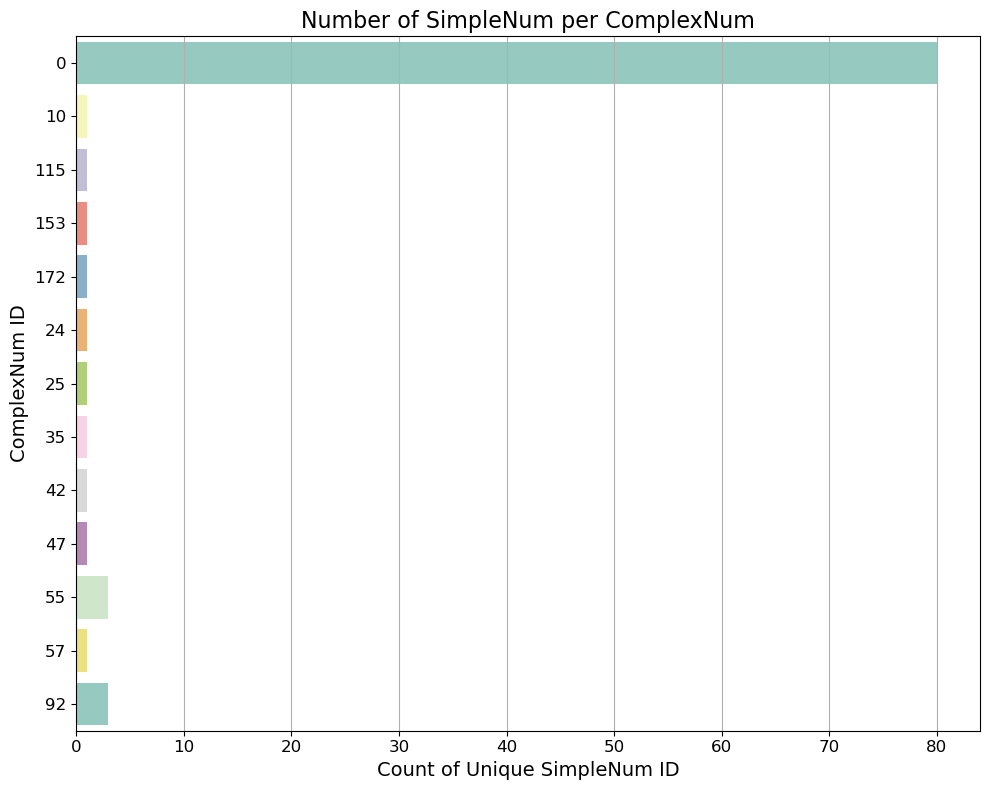

In [20]:
# Count number of unique SimpleNum per ComplexNum
simple_counts = df.groupby('ComplexNum')['SimpleNum'].nunique().reset_index(name='NumSimple')

# Sort (optional, for better visuals)
#simple_counts = simple_counts.sort_values(by='NumSimple', ascending=False)

# Plot 1
plt.figure(figsize=(10, 8))
sns.barplot(y='ComplexNum', x='NumSimple', data=simple_counts, palette='Set3')
plt.title('Number of SimpleNum per ComplexNum', fontsize=16)
plt.xlabel('Count of Unique SimpleNum ID', fontsize=14)
plt.ylabel('ComplexNum ID', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='x')
plt.show()


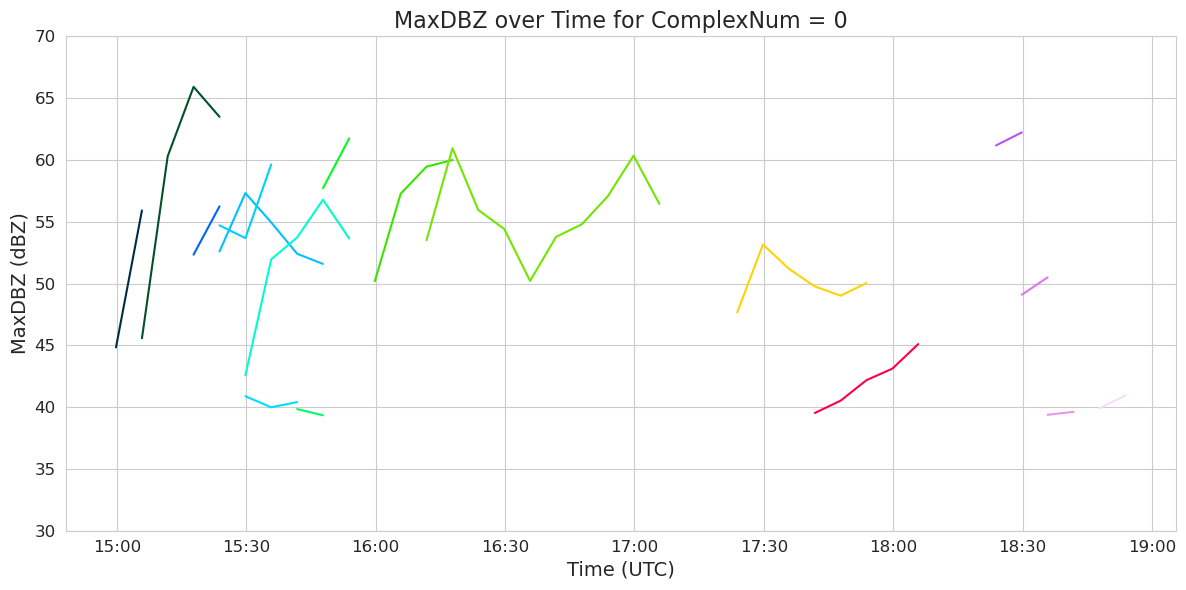

In [21]:
#  Filter dataframe for ComplexNum == 0 and sort by time
df0 = df[df['ComplexNum'] == "0"].copy()
df0 = df0.sort_values('date_utc')
df0['MaxDBZ(dBZ)'] = pd.to_numeric(df0['MaxDBZ(dBZ)'], errors='coerce')
df0['date_utc'] = pd.to_datetime(df0['date_utc'], errors='coerce', utc=True)

#  Plot
y_min = 30
y_max = 70
y_ticks = np.arange(y_min, y_max + 1, 5)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(data=df0, x='date_utc', y='MaxDBZ(dBZ)', hue='SimpleNum', palette='gist_ncar')
plt.ylim(y_min, y_max)
plt.yticks(y_ticks,fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(fontsize=12)
plt.title('MaxDBZ over Time for ComplexNum = 0', fontsize=16)
plt.xlabel('Time (UTC)', fontsize=14)
plt.ylabel('MaxDBZ (dBZ)',fontsize=14)
# Remove legend
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()


Now we can also plot the centroids of each tracked cell, in a Cartopy map, and add circles around the centroid based on how big the cell volume is in each timestep. We will also show the different cells ('SimpleNum') in different colors.

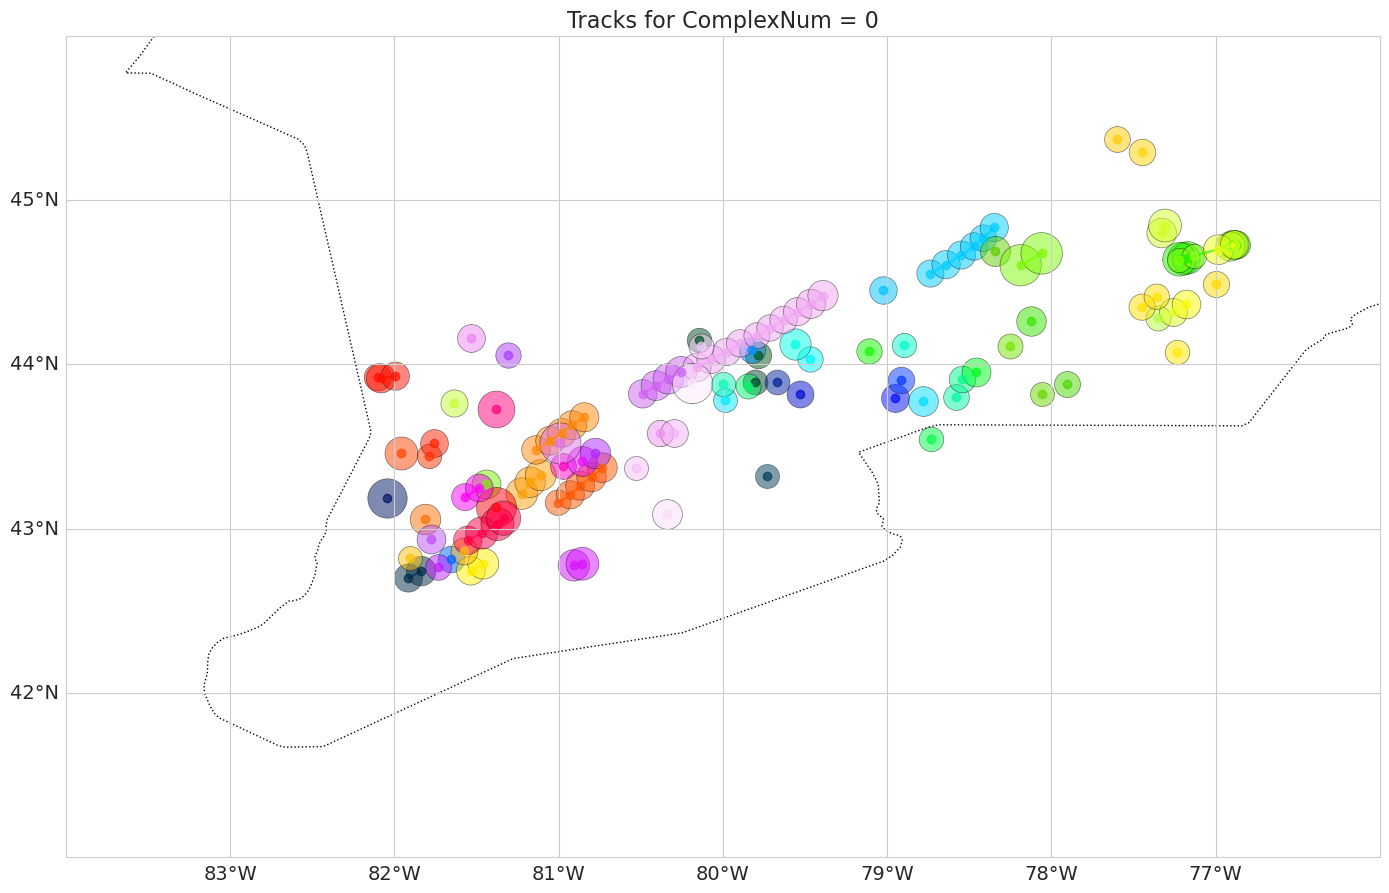

In [22]:
df0 = df0.sort_values(['SimpleNum', 'date_utc'])
# Convert lat/lon columns to numeric, coercing errors to NaN
df0['VolCentroidLat(deg)'] = pd.to_numeric(df0['VolCentroidLat(deg)'], errors='coerce')
df0['VolCentroidLon(deg)'] = pd.to_numeric(df0['VolCentroidLon(deg)'], errors='coerce')

# Set up map plot
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-84, -76, 41, 46], crs=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

# Unique SimpleNum and colors
simple_nums = df0['SimpleNum'].unique()
palette = sns.color_palette("gist_ncar", n_colors=len(simple_nums))
df0['Volume(km3)'] = pd.to_numeric(df0['Volume(km3)'], errors='coerce').fillna(0)

# We normalize the Volume for the marker sizes
for i, simple_num in enumerate(simple_nums):
    track = df0[df0['SimpleNum'] == simple_num].copy()

    lat = track['VolCentroidLat(deg)']
    lon = track['VolCentroidLon(deg)']
    vol = pd.to_numeric(track['Volume(km3)'], errors='coerce').fillna(0)

    # Scale volume: use log scale to compress range + clip to reasonable range
    sizes = np.log10(vol + 1) * 200  # +1 to avoid log(0)
    #sizes = sizes.clip(10, 300)      

    ax.plot(lon, lat, marker='o', linestyle='-', color=palette[i], alpha=0.7, transform=ccrs.PlateCarree())
    ax.scatter(lon, lat, s=sizes, color=palette[i], alpha=0.5, transform=ccrs.PlateCarree(), edgecolor='k', linewidth=0.5)

#plt.legend(title='SimpleNum', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Tracks for ComplexNum = 0', fontsize= 16)
plt.tight_layout()
plt.show()


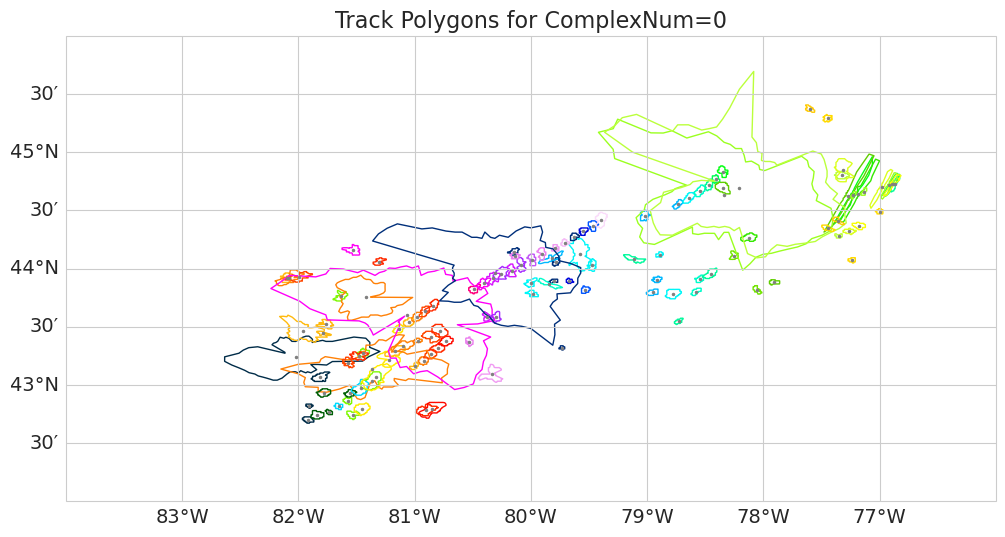

In [23]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the map extent (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([-84, -76, 42, 46], crs=ccrs.PlateCarree())
ax.coastlines()

#color by time
timesteps = df0['date_utc'].unique()
palette = sns.color_palette("gist_ncar", n_colors=len(timesteps))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

for idx, row in df0.iterrows():
    lat_centroid = float(row['EnvelopeCentroidLat(deg)'])
    lon_centroid = float(row['EnvelopeCentroidLon(deg)'])
    rays = row['nPolySidesPolygonRays']
    
    if not rays or len(rays) == 0:
        continue  
    
    angles = np.deg2rad(np.arange(0, 360, 5))  # 72 vertices at every 5 degrees
    rays = np.array(rays, dtype=float) #from centroid to vertex
    
    # Rays in km to degrees
    ray_x = rays * np.cos(angles)
    ray_y = rays * np.sin(angles)

    # Approximate conversion from km to degrees lat/lon
    lat_vertices = lat_centroid + ray_y / 111
    lon_vertices = lon_centroid + ray_x / (111 * np.cos(np.deg2rad(lat_centroid)))

    polygon_points = list(zip(lon_vertices, lat_vertices))
    
    poly = Polygon(polygon_points)
    time_idx = np.where(timesteps == row['date_utc'])[0][0]

    ax.add_geometries([poly], crs=ccrs.PlateCarree(),
                      edgecolor=palette[time_idx], facecolor='none', linewidth=1)
    
    ax.plot(lon_centroid, lat_centroid, marker='o',color='grey', markersize=1.5, transform=ccrs.PlateCarree())



plt.title("Track Polygons for ComplexNum=0", fontsize=16)
plt.show()


# Afternoon Project

To run TITAN on the hail case, the previous commands just need to be recreated using the hail parameter files. We've summarized the commands below.

1. Convert the data.
<code lang="bash">!$LROSE_DIR/RadxConvert -sort_rays_by_time -const_ngates -params ./params/titan/RadxConvert.qc.hail -debug -f ${DATA_DIR}/radar/raw/hail/202408060*h5</code>

2. Prepare the sounding data.
<code lang="bash">!$LROSE_DIR/Mdv2SoundingSpdb -debug -params ./params/titan/Mdv2SoundingSpdb.ERA5.hail -f $DATA_DIR/ERA5/20240806/20240806_0*</code>

3. Run the PID.
<code lang="bash">!$LROSE_DIR/RadxPid -params ./params/titan/RadxPid.hail -debug</code>

4. Grid the data on a Cartesian grid.
<code lang="bash">!$LROSE_DIR/Radx2Grid -params ./params/titan/Radx2Grid.hail -debug</code>

5. Run TITAN.
<code lang="bash">!$LROSE_DIR/Titan -params ./params/titan/Titan.hail -start "2024 08 06 00 00 00" -end "2024 08 06 06 00 00" -debug</code>

6. Convert the tracks to an ASCII file.
<code lang="bash">!$LROSE_DIR/Tracks2Ascii -params ./params/titan/Tracks2Ascii.hail -f ~/data/ams2025/titan/storms/Strathmore/20240806.th5 > $DATA_DIR/titan/ascii/Tracks2Ascii.hail.txt</code>

7. Convert the output to NetCDF.
<code lang="bash">!$LROSE_DIR/Tstorms2NetCDF -params ./params/titan/Tstorms2NetCDF.hail -debug -f $DATA_DIR/titan/storms/Strathmore/20240806.sh5</code>


### Play with the reflectivity or minimum area thresholds

<div class="alert alert-block alert-info"> <b>File Task: modify parameters in text files.</b> 

If you're curious how the parameter choices affect the analysis, feel free to play around with different values of the reflectivity and minimum area thresholds.

These are in the ./params/titan/Titan.hail and ./params/titan/Titan.derecho parameter files, which you can edit directly in JupyterLab.

</div>